# Authors: Eyal Stolov and Itay Grandenwits


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import shap
import warnings
import optuna
from xgboost import XGBRegressor
warnings.filterwarnings("ignore")


# Data Preparation

In [2]:
dfr = pd.read_csv('./data/winequality-red.csv', sep=';')
target = 'quality'

In [56]:
dfr.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [57]:
list(dfr.columns)

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality',
 'wine_type']

#### Let'd check for missing values:

In [58]:
dfr.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine_type               0
dtype: int64

#### No missing values.

#### Splitting target and features

In [61]:
X = dfr.drop(columns=[target])
y = dfr[target]

#### Splitting to train and test - We split 75% to train, and we stratify to balance the minority classes in the training and test set

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

#### Let's examine their distributions:

In [5]:
def compare_distributions(y_1, y_2,y1_name='First Distribution', y2_name = 'Second Distribution'):
    # Create histograms with Seaborn
    plt.figure(figsize=(12, 6))

    # Plot original y_train histogram
    plt.subplot(1, 2, 1)
    sns.histplot(y_1, bins=np.arange(min(y_1), max(y_1) + 2), kde=False, color='skyblue', edgecolor='black')
    plt.title(f'Histogram Of {y1_name}')
    plt.xlabel('Class')
    plt.ylabel('Frequency')

    # Plot oversampled y_train_smote histogram
    plt.subplot(1, 2, 2)
    sns.histplot(y_2, bins=np.arange(min(y_2), max(y_2) + 2), kde=False, color='salmon', edgecolor='black')
    plt.title(f'Histogram Of {y2_name}')
    plt.xlabel('Class')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

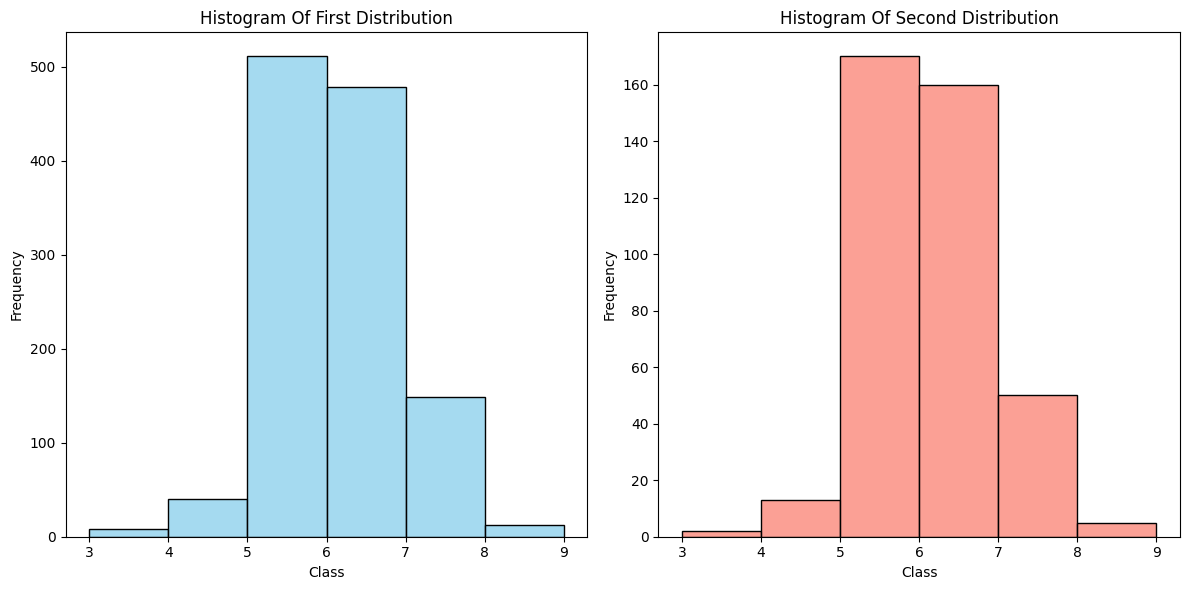

In [6]:
compare_distributions(y_train, y_test)

#### The histograms look alike, so we can tell that the split was done correctly

#### This function will help us understand if we improved after each step

In [7]:
def calculate_scores(y_true, y_pred, image_name = None, target_names=['3', '4', '5', '6', '7', '8']):
    report = classification_report(
    y_true, y_pred, target_names=target_names, output_dict=True
    )

    df_report = pd.DataFrame(report).transpose()

    df_report = df_report.drop(columns=['support'], errors='ignore')

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        df_report.iloc[:-1, :].astype(float),
        annot=True, cmap="YlGnBu", cbar=True, fmt=".2f", linewidths=0.5,
    )

    plt.title('Classification Report', fontsize=16, weight='bold')
    plt.xlabel('Metrics', fontsize=14)
    plt.ylabel('Classes', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.tight_layout()

    if image_name:
        plt.savefig(f'./images/{image_name}', dpi=300, bbox_inches='tight')

In [78]:
def calculate_confusion_matrix(y_true, y_pred, image_name=None):

    classes = sorted(set(y_true))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()

    if image_name:
     plt.savefig(f'./images/{image_name}', dpi=300, bbox_inches='tight')

#### And this function to comapre 2 different classification reports:

In [9]:
def compare_scores(path_result_1, path_result_2, headline_1, headline_2):
    first_pipeline_results = mpimg.imread(path_result_1)
    second_pipeline_results = mpimg.imread(path_result_2)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].imshow(first_pipeline_results)
    axes[0].axis('off')  # Hide the axes
    axes[0].set_title(headline_1)

    # Display the second image
    axes[1].imshow(second_pipeline_results)
    axes[1].axis('off')  # Hide the axes
    axes[1].set_title(headline_2)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Basic Pipeline:
Let's start with a basic pipline and later, we'll perform an error analysis technices to imporve the inital results:

This is a method to round the predictions from regressor mdoel. we need to do that becasue the target feature - target, is a distinct feature.

In [66]:
def round_results(y_pred):
     # Convert predictions to rounded values
    rounded_values = [round(value) for value in y_pred]

    # Create DataFrame with 'quality' as the header
    df = pd.DataFrame(rounded_values, columns=[target])
    
    return df

Let's train a basic XGB model:

In [106]:
basic_model = XGBRegressor(
    max_depth=6,                # Limit tree depth
    learning_rate=0.05,         # Lower learning rate
    n_estimators=500,           # More estimators with small steps
    subsample=0.8,              # Row subsampling
    colsample_bytree=0.8,       # Feature subsampling
    reg_alpha=0.5,              # L1 regularization
    reg_lambda=1,               # L2 regularization
    gamma=1,                    # Prune unnecessary splits
    min_child_weight=5,
    random_state=42         # Minimum leaf weight
)
basic_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Let's see if there exsist an overfitting:

In [64]:
y_reg_test = basic_model.predict(X_test)
y_reg_train = basic_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_reg_train)
test_mse = mean_squared_error(y_test, y_reg_test)
print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Training MSE: 0.19995684921249063
Test MSE: 0.35837376153579953


$MSE_{\text{test}} < MSE_{\text{train}}$, which means we have an overfitting. 
We'll handel it later with hyper parameters tuning.

Now let's look at the classification report for the basic pipline

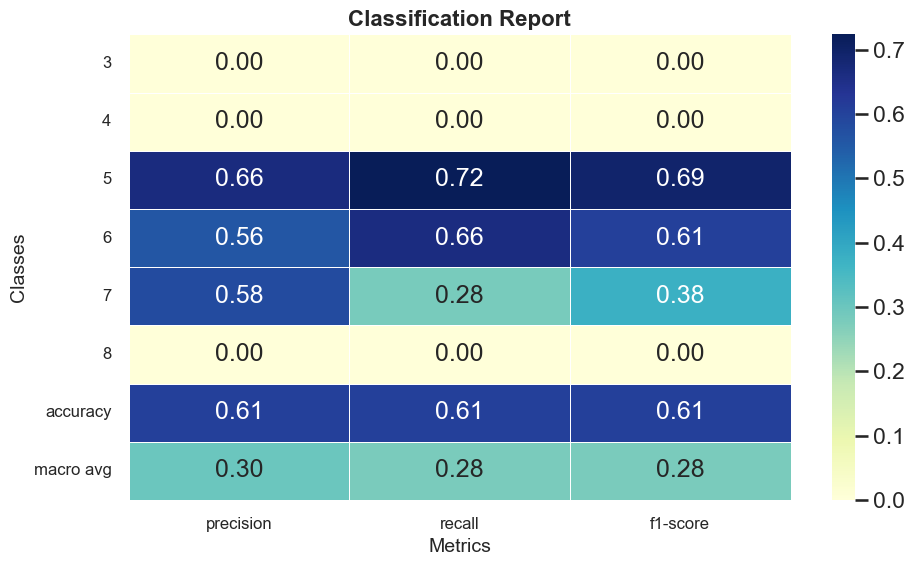

In [68]:
y_pred = round_results(y_reg_test)
calculate_scores(y_test, y_pred, 'basic-pipline-results')

 #### Key Takeaways from the Classification Report:
## Class Performance:
- **Class 3:**
  - Poor performance with all metrics (`precision`, `recall`, and `f1-score`) being **0**.
  - The model failed to correctly classify any instances of this class.

- **Class 4:**
  - Poor performance with all metrics (`precision`, `recall`, and `f1-score`) being **0**.
  - The model failed to correctly classify any instances of this class.


- **Class 5:**
  - Fairly balanced performance with `precision` (**0.66**), `recall` (**0.72**), and `f1-score` (**0.69**).
  - Shows reasonable performance for this class.

- **Class 6:**
  - Slightly worse `precision` (**0.56**) and `recall` (**0.66**) leading to a `f1-score` (**0.61**).
  - Indicates some imbalance in predictions.

- **Class 7:**
  - Moderate results with `precision` (**0.58**) but lower `recall` (**0.28**), leading to an `f1-score` of **0.38**.

- **Class 8:**
  - Poor performance with all metrics (`precision`, `recall`, and `f1-score`) being **0**.
  - The model failed to correctly classify any instances of this class.

## Aggregate Metrics:
- **Accuracy:**
  - The overall accuracy is **0.61**, meaning roughly two-thirds of predictions were correct.

- **Macro Average:**
  - `Precision` (**0.61**), `recall` (**0.61**), and `f1-score` (**0.61**) reflect significant disparity in class-wise performance.

## Areas for Improvement:
- Significant attention is needed for **Class 3**, **Class 4** and **Class 8** as their metrics are substantially low.
- Hyper parameters tuning is neccessary to avoid oferfitting and improve the score.
- Balancing class-wise performance is critical, as shown by the discrepancy between the macro averages and overall accuracy.

## Balanced Classes:
- **Class 5** and **Class 6** exhibit the most balanced performance among the classes, indicating bias in the model towards those clsses. This can be shown with an high recall for class 5 but less high precision, this is due to the model probably predict *5* or *6* for most instances.

By addressing the weaknesses in specific classes, the overall performance of the classification model can be improved.


#### And let's view the confusion matrix for that pipline to get an even deeper understanding about the model's errors:

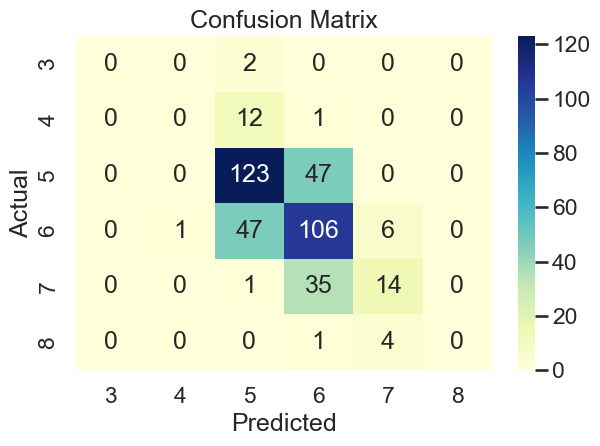

In [82]:
calculate_confusion_matrix(y_test, y_pred, image_name='basic-pipline-confusion-matrix')

 ### Key Takeaways from the Classification Report:
Like we mentioned before, the model appears to be biased toward the middle class, as the majority of predictions fall into that category.

To asses our prediction about the model biasedm let's try to undersmaple the majority classes, and then train the model again.
If our prediction upon the model bias is correct, we expect to see the errors spread more evenly.

To undersample the data, we use `RandomUnderSampler`:

In [71]:
rus = RandomUnderSampler(random_state=42)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

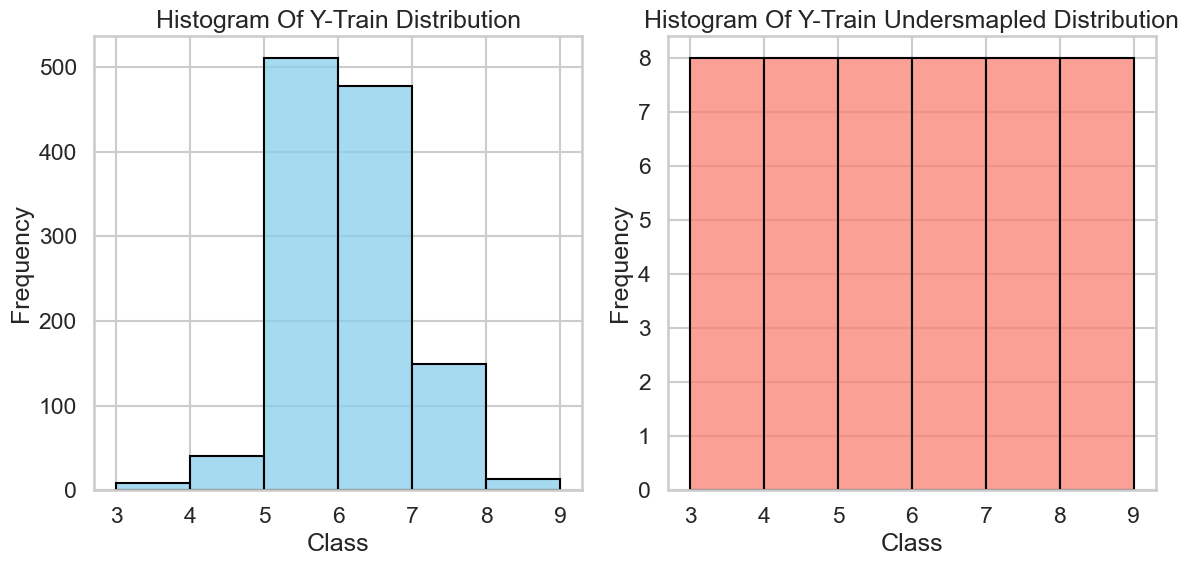

In [72]:
compare_distributions(y_train, y_train_undersampled, y1_name='Y-Train Distribution', y2_name='Y-Train Undersmapled Distribution')

We undersampled all classes to have 8 samples each. Let's see what the basic model manages to learn right now:

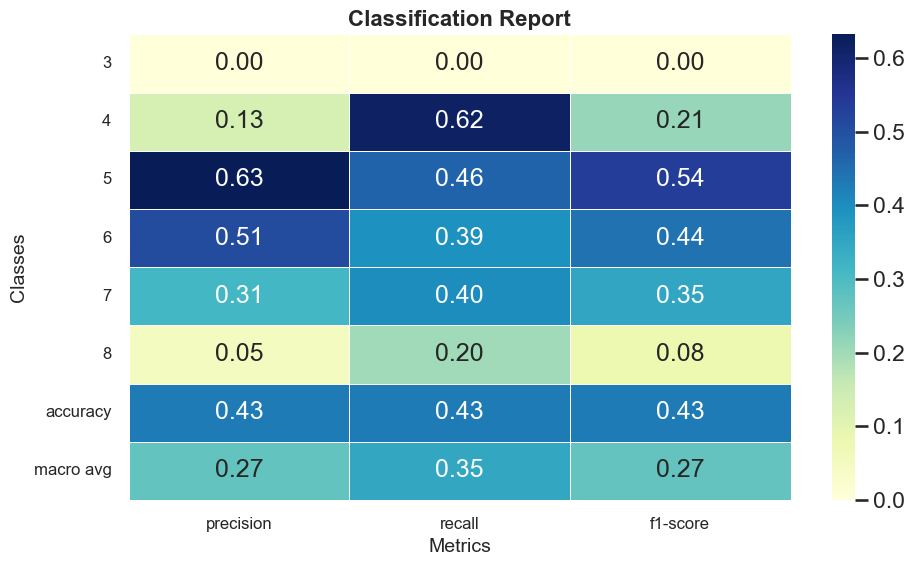

In [75]:
basic_model.fit(X_train_undersampled, y_train_undersampled)
y_pred_undersampled = round_results(basic_model.predict(X_test))
calculate_scores(y_true = y_test, y_pred = y_pred_undersampled, image_name='basic-pipline-undersampled-results')


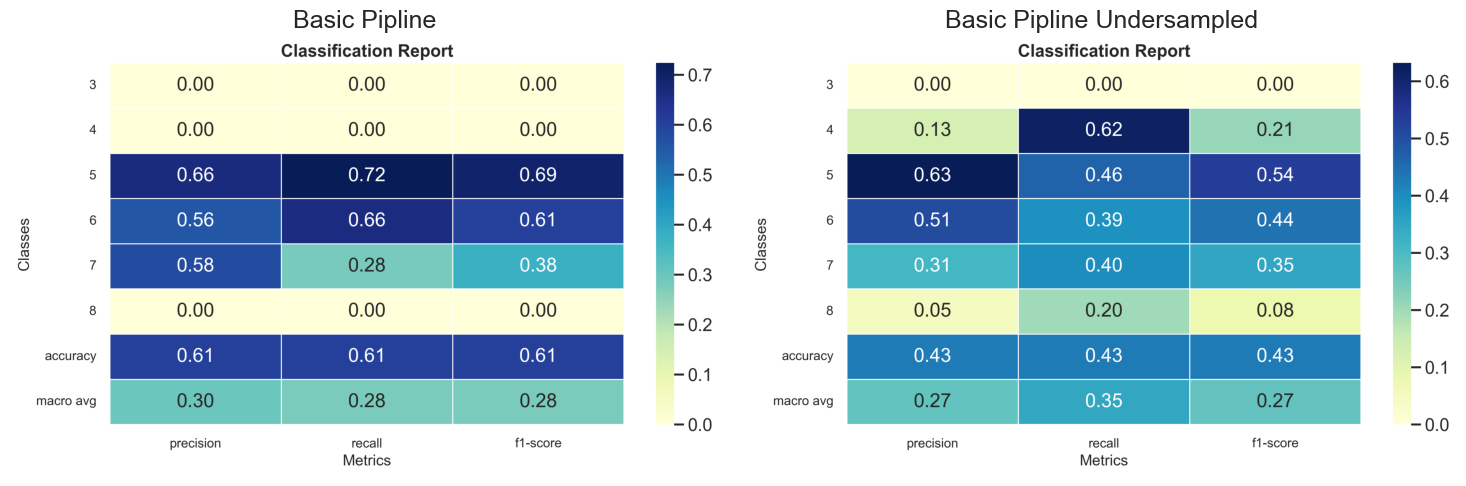

In [76]:
compare_scores(path_result_1='./images/basic-pipline-results.png',
               path_result_2='./images/basic-pipline-undersampled-results.png',
                headline_1='Basic Pipline',
                headline_2='Basic Pipline Undersampled')

### Key Takeaways from the Classification Report:
- **Class 5:** Exhibits lower recall and higher precision, meaning fewer false positives but also fewer true positives. This suggests the model predicts this class less frequently than before.
- **Class 6:** Shows a similar drop in recall, but precision is also lower. We need to compare the confusion matrices to better understand why this happens. Overall, it seems the model is less likely to predict this class as well.
- **Classes 4 and 7:** Have higher recall and lower precision. This could be explained by fewer predictions from Class 8 falling into these classes, possibly due to bias toward the middle classes.
- **Classes 3 and 8:** Still have very low scores. We need to analyze the confusion matrix further to gain better insights into the reasons.

Now let's look at the confusion matrix to gain better understaning aobut the errors:

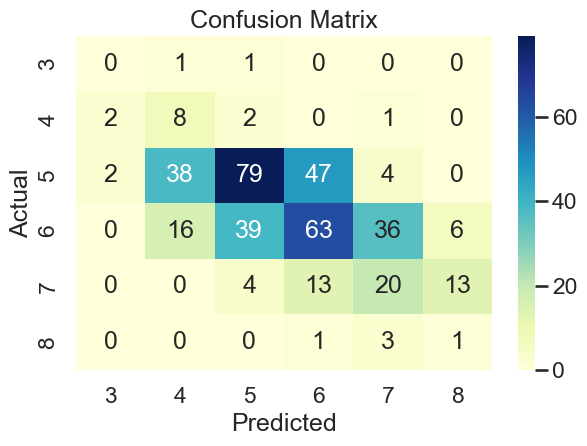

In [81]:
calculate_confusion_matrix(y_true = y_test, y_pred = y_pred_undersampled, image_name='basic-pipline-undersampled-confusion-matrix')

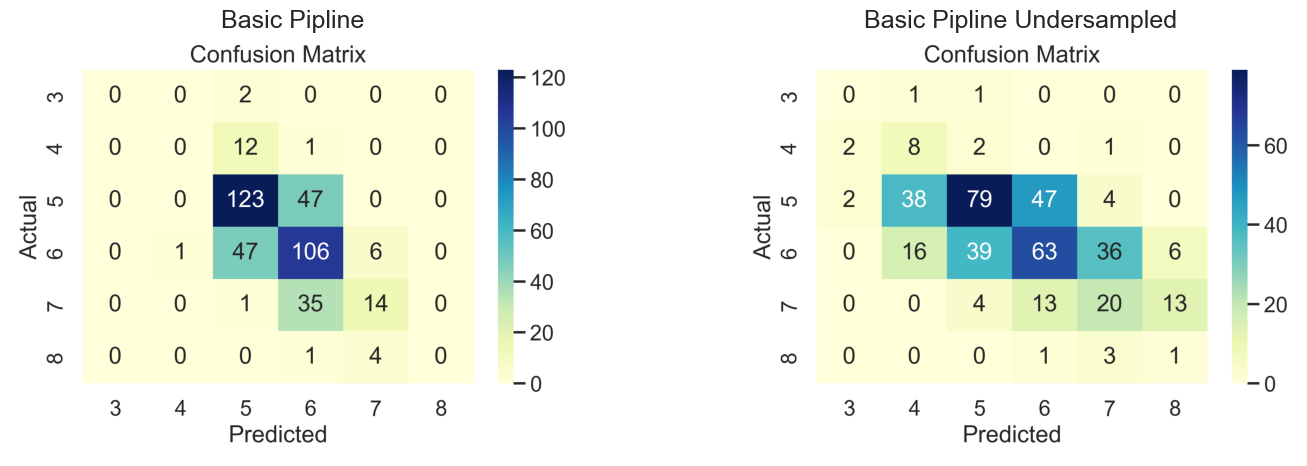

In [83]:
compare_scores(path_result_1='./images/basic-pipline-confusion-matrix.png',
               path_result_2='./images/basic-pipline-undersampled-confusion-matrix.png',
                headline_1='Basic Pipline',
                headline_2='Basic Pipline Undersampled')

### Key Takeaways from the Classification Report:
- The prediction are spread more evenly for each class which meand that the basic model was indeed biased toward the majority clsses.
- Sample size for classes 3,8 in the test samples is very very low. This could explain the low scores for those classes comapring the other classes.
  This could really harm the error analysis later bacuse 2-5 samples is not enough to asses a score.

Let's try to undersample the majortity classes on the __test__ data set as well, and then see if the results turn out to be bad there as well:

In [18]:
X_test_undersampled, y_test_undersampled = rus.fit_resample(X_test, y_test)

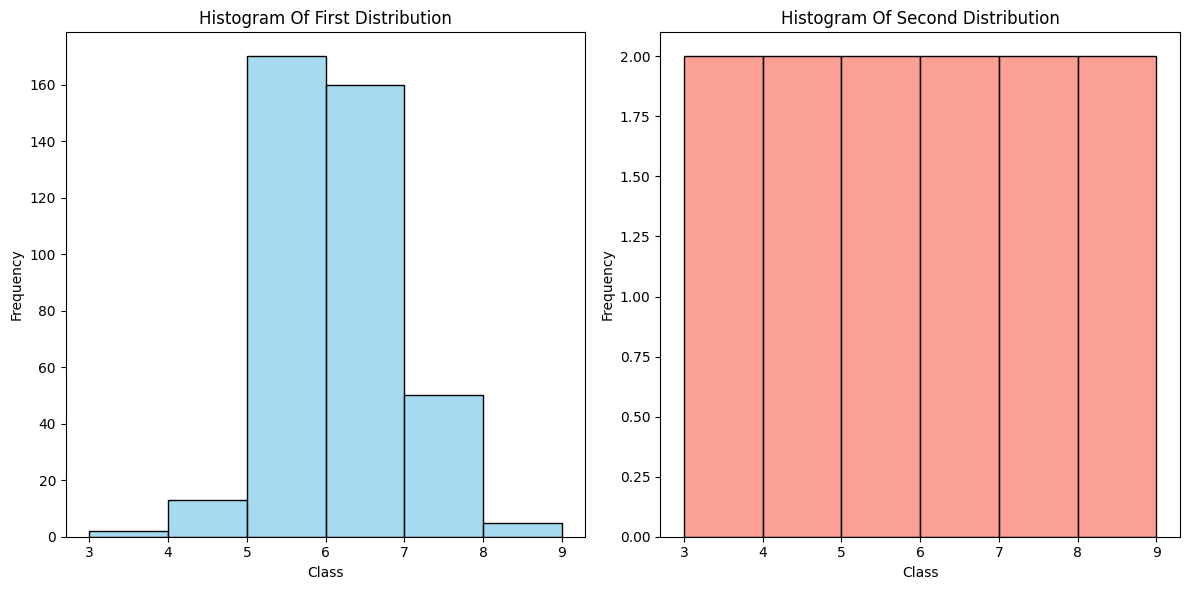

In [19]:
compare_distributions(y_test, y_test_undersampled)

Now let's see if there still exitst some kind of a biased towrads the middle classes:

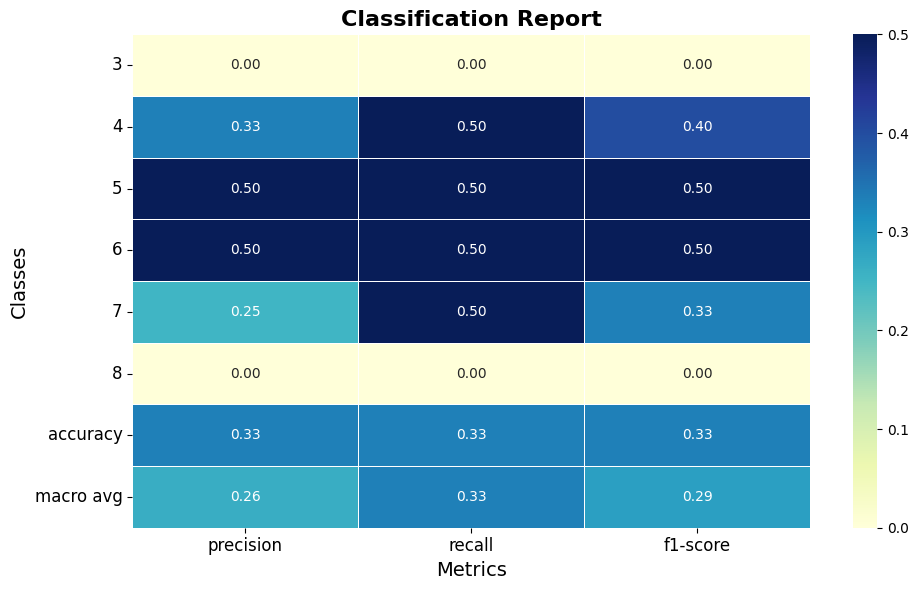

In [20]:
y_pred_undersapmled = round_results(basic_model.predict(X_test_undersampled))
calculate_scores(y_test_undersampled, y_pred_undersapmled)

And a confusion matrix:

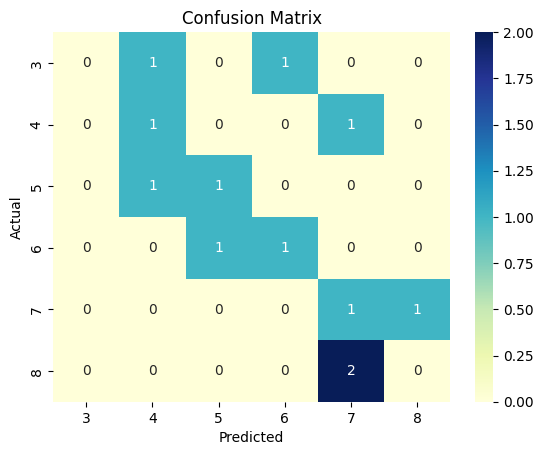

In [21]:
calculate_confusion_matrix(y_true = y_test_undersampled, y_pred = y_pred_undersapmled)

- It might be randomic but it's quite weird for us that just the minority classes didn't get any prediction right.
There is no excuse for that to happen now, the train samples amount and test samples amount are equals for each class.
- Anyway, we came to an understanding that the samples amount on minority classes for the test samples are too small to infer any realaistic insights.
- Also good to note that the amount is so small that it's not possible to use some oversampling method to generate more data for them.
We __need__ to get more data for the minority classes.


 The immidiate conclusion is that we __have__ to get more data for the minority classes, otherwise it won't be possible to get a representive score for the model in those areas.

### Introuduce White-Wine Quality Data Set

Let us indrouduce the winequality-white data set that contains sample represeting white wines.
  It's the same data set but for white wines.
  The ideas is to concat them toghether and use more data.


In [86]:
dfw = pd.read_csv('./data/winequality-white.csv', sep=';')
dfr = pd.read_csv('./data/winequality-red.csv', sep=';')
target = 'quality'

In [89]:
dfw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [90]:
list(dfr.columns)

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [91]:
dfr.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

It's indeed excatly the same data set and there are is no missing data here as well.

### Concat The Data Sets Together
Let's concat the data sets togheter and add a `wine_type` column to distinguish between them.

In [93]:
dfw['wine_type'] = 0
dfr['wine_type'] = 1
dfc = pd.concat([dfw, dfr], ignore_index=True)


In [95]:
X = dfc.drop(columns = [target])
y = dfc[target]

#### Let's look at the full data set distribution:

<Axes: >

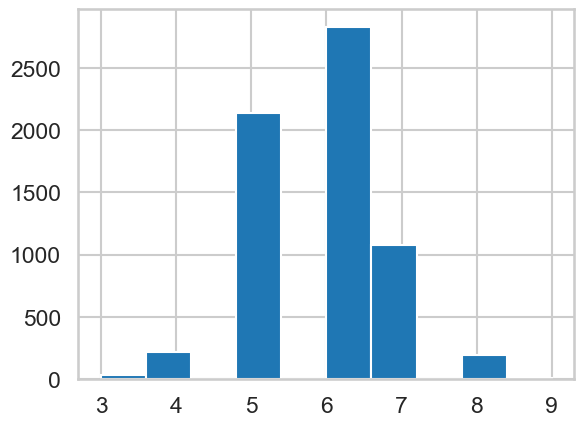

In [96]:
y.hist()

- Classes 3,8 - still a low amount of samples, but should be enough for an error analysis.
- Class 9 - Really small amount of samples - we'll probably encouter the same problem from before.
  To avoid the same problem for the 9th class, we'll change every apperence of that class to be 8. Although it's kinda a cheat, it neccessary for a good EA.

Set class 9 to be 8.

<Axes: >

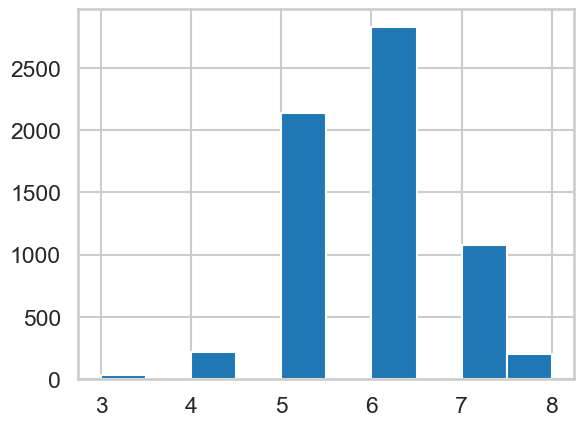

In [98]:
y[y==9] = 8
y.hist()

#### Splitting to train and test again

In [99]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

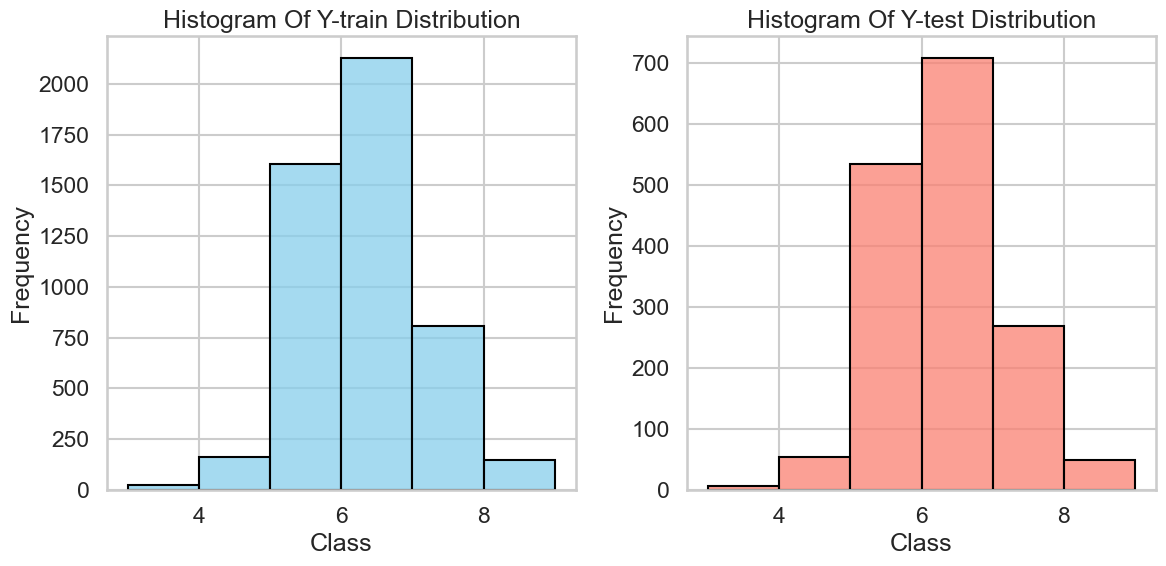

In [102]:
compare_distributions(y_train, y_test, y1_name='Y-train Distribution', y2_name='Y-test Distribution')

- First, the split was done correctly and the distribution of the train and test samples are alike.
- Second, The huge imbalnce in the data still exists, class 3 has aorund 20 values while class 6 has over 2000 samples.
  We'll need to handle it later like we did above.

## Basic Model Full Data

In [107]:
xgboost_basic_model = XGBRegressor(
    max_depth=6,                # Limit tree depth
    learning_rate=0.05,         # Lower learning rate
    n_estimators=500,           # More estimators with small steps
    subsample=0.8,              # Row subsampling
    colsample_bytree=0.8,       # Feature subsampling
    reg_alpha=0.5,              # L1 regularization
    reg_lambda=1,               # L2 regularization
    gamma=1,                    # Prune unnecessary splits
    min_child_weight=5,
    random_state=42         # Minimum leaf weight
)

In [108]:
xgboost_basic_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [109]:
y_reg_test = xgboost_basic_model.predict(X_test)
y_reg_train = xgboost_basic_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_reg_train)
test_mse = mean_squared_error(y_test, y_reg_test)
print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Training MSE: 0.2557519703554966
Test MSE: 0.4146909872994833


$MSE_{\text{test}} < MSE_{\text{train}}$, which means we have an overfitting. 
We'll handel it later with hyper parameters tuning.

#### Basic Model Full Data Score:

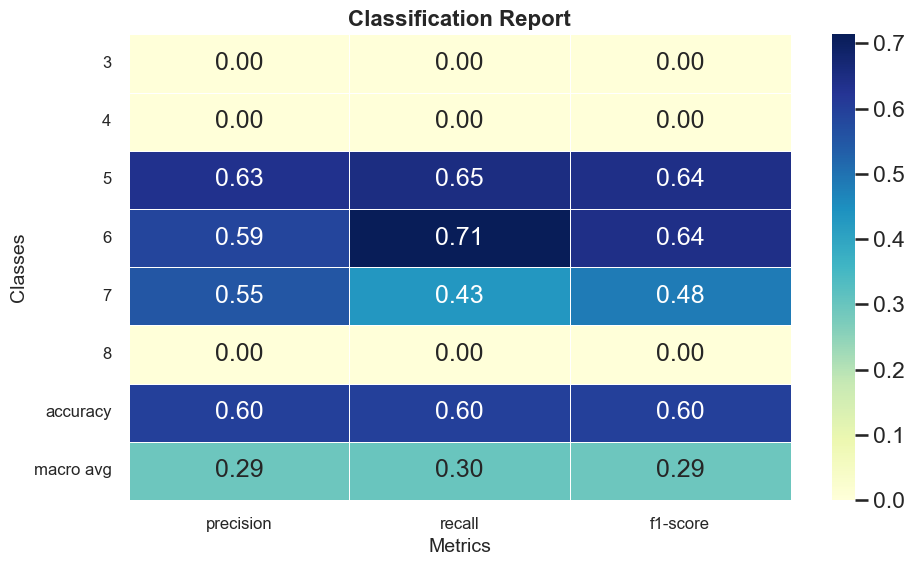

In [122]:
y_pred = round_results(y_reg_test)
calculate_scores(y_true=y_test, y_pred=y_pred, image_name='basic-pipline-full-data-results')

#### Basic Model Full Fata Confusion Matrix

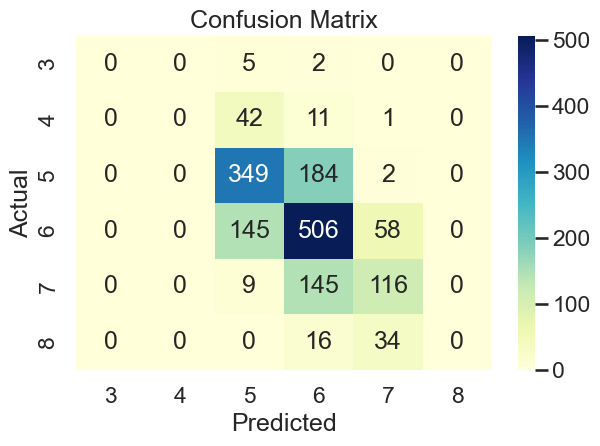

In [123]:
calculate_confusion_matrix(y_true=y_test, y_pred=y_pred, image_name='basic-pipline-full-data-matrix')

### Key takeways from the score report and teh confusion matrix:
- Similiar to the previous data set, the ibalance in the data very dominant and the model is biased towrds the majority classes.
- There exist now a sufficient amount of samples in class 8 - so EA we'll be more effective.
- The test samples amount of class is worrying and might harden the EA proccess there.

### Balancing The Data

As we've already seen above, data balncing is very affective to cancel the model bias towrads the majority classes.
This time we'll oversample the minority classes instead of undersample the majoirty. for that we'll use `SMOTE`.

In [124]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

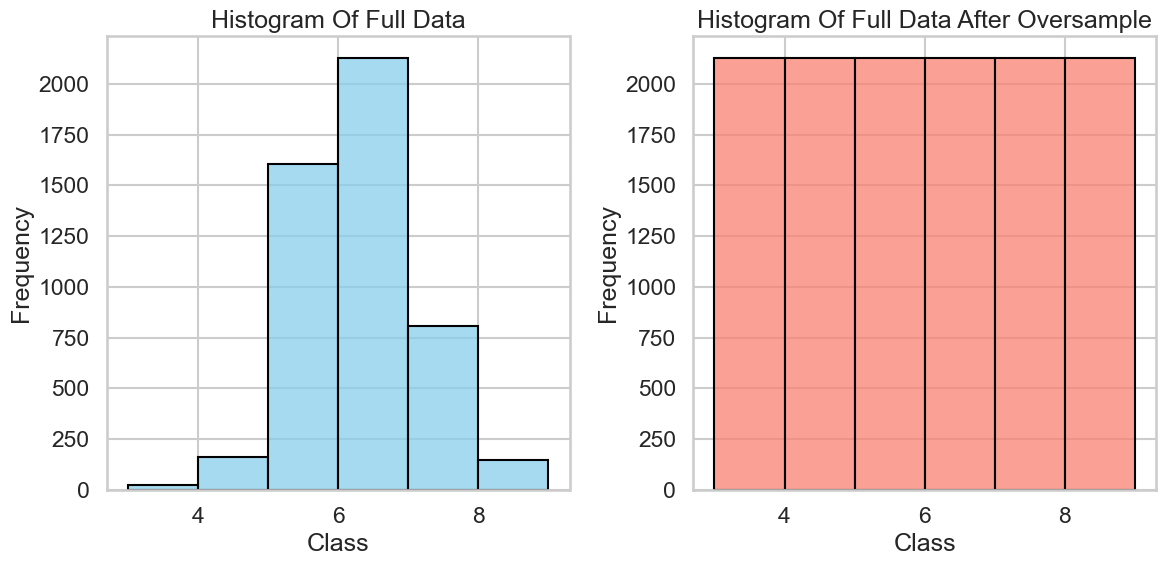

In [125]:
compare_distributions(y_train, y_train_smote, y1_name='Full Data', y2_name='Full Data After Oversample')

### Train the model on balanced data

In [126]:
xgboost_basic_model.fit(X_train_smote, y_train_smote)
y_pred = round_results(xgboost_basic_model.predict(X_test))

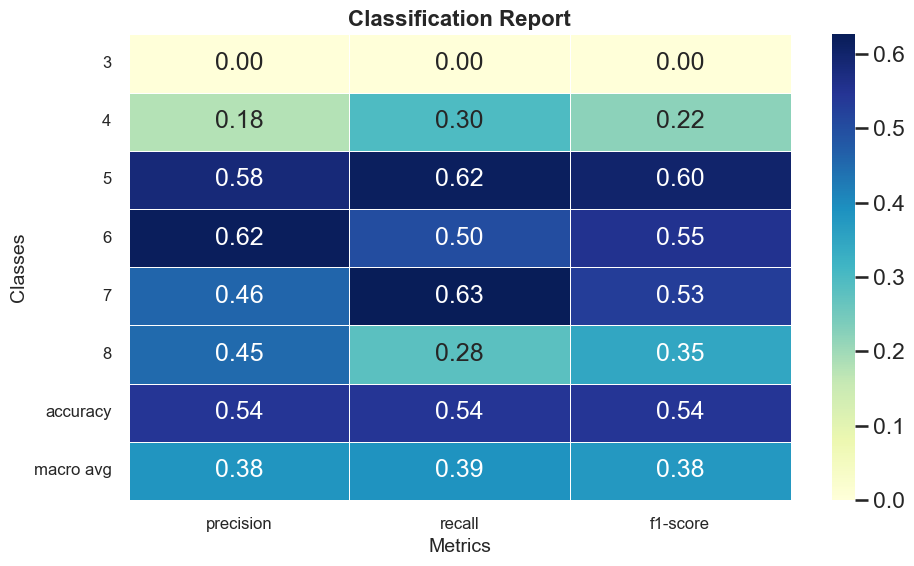

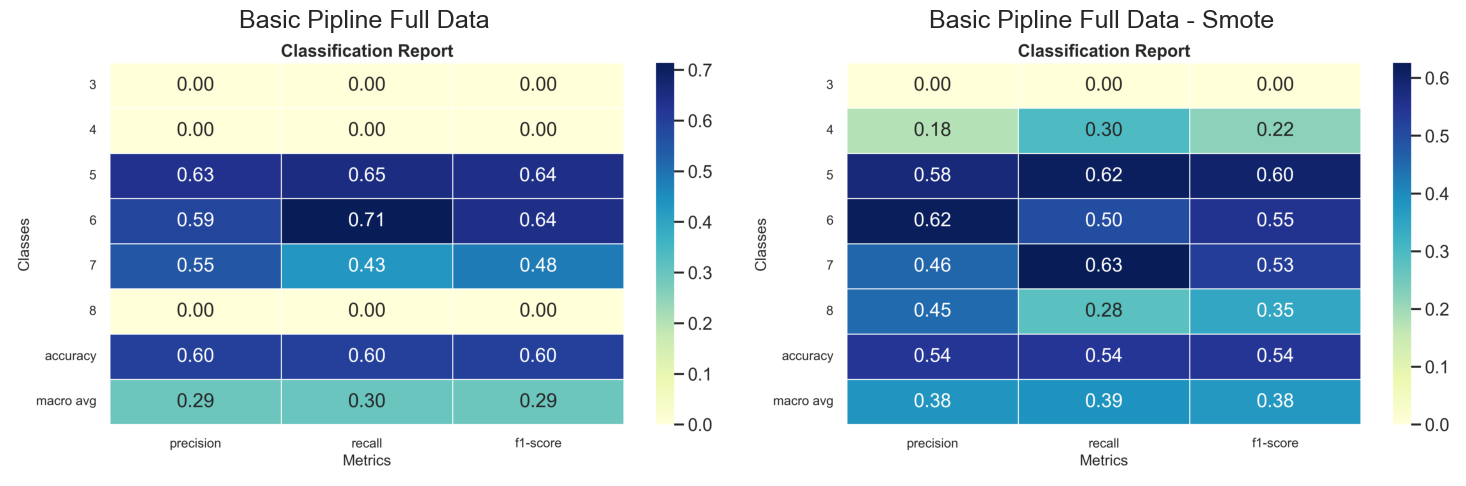

In [127]:
calculate_scores(y_true=y_test, y_pred=y_pred, image_name='basic-pipline-full-data-smote-results')
compare_scores(path_result_1='./images/basic-pipline-full-data-results.png',
               path_result_2='./images/basic-pipline-full-data-smote-results.png',
                headline_1='Basic Pipline Full Data',
                headline_2='Basic Pipline Full Data - Smote')

Also let's watch the confusion matrices:

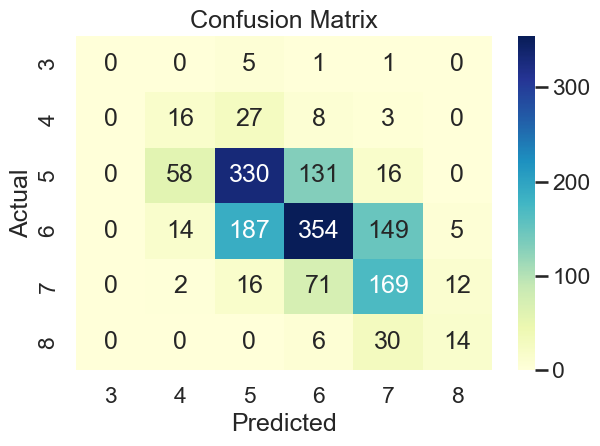

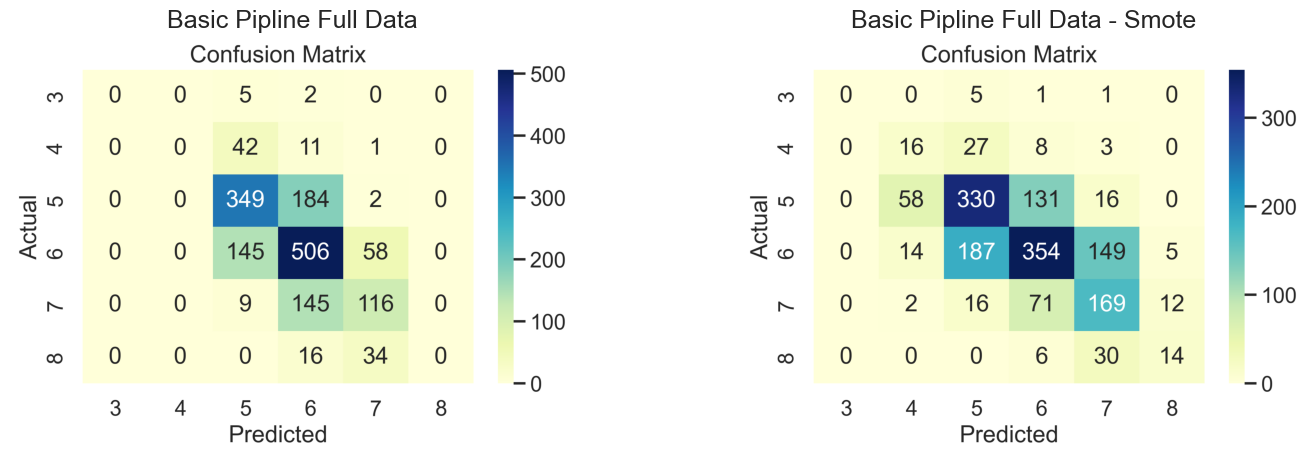

In [128]:
calculate_confusion_matrix(y_true=y_test, y_pred=y_pred, image_name='basic-pipline-full-data-smote-matrix')
compare_scores(path_result_1='./images/basic-pipline-full-data-matrix.png',
               path_result_2='./images/basic-pipline-full-data-smote-matrix.png',
                headline_1='Basic Pipline Full Data',
                headline_2='Basic Pipline Full Data - Smote')


to do: add insights:

### Error Analysis + Feature Engeneering

Let us indtrouduce 2 method to evaluate feature performance for a model:

This model shows the feature overall importance for the model:

In [39]:
def plot_importance(model, X):
    importances_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    sns.set_style("whitegrid")
    sns.set_context("talk")
    sns.barplot(
        data=importances_df,
        x='Importance',
        y='Feature',
        palette='Blues_d',
    )
    plt.tight_layout()

    plt.show()


And this one plot the shap values of the model group by the samples classes:

In [40]:
def plot_shap_values_by_classes(shap_values, X_test, y_test, classes_numbers=[3,4,5,6,7,8]):
    plt.figure(figsize=(40, 30))
    for idx, i in enumerate(classes_numbers):
        ax = plt.subplot(3, 2, idx + 1)  # Create subplot
        shap.summary_plot(
        shap_values[y_test == i],
        X_test[y_test == i],
        show=False,
        plot_size=(15, 18),
        )
        ax.set_title(f"SHAP Summary - Quality {i}", fontsize=16)
    # Adjust the layout and display the plots
    plt.tight_layout(pad=3.0)
    plt.show()

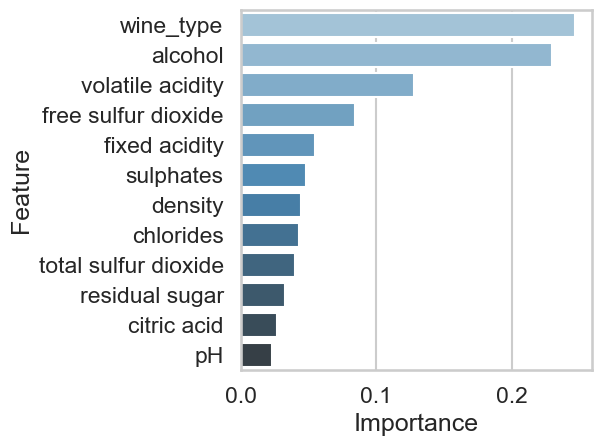

In [41]:
plot_importance(model=xgboost_basic_model, X=X_test)

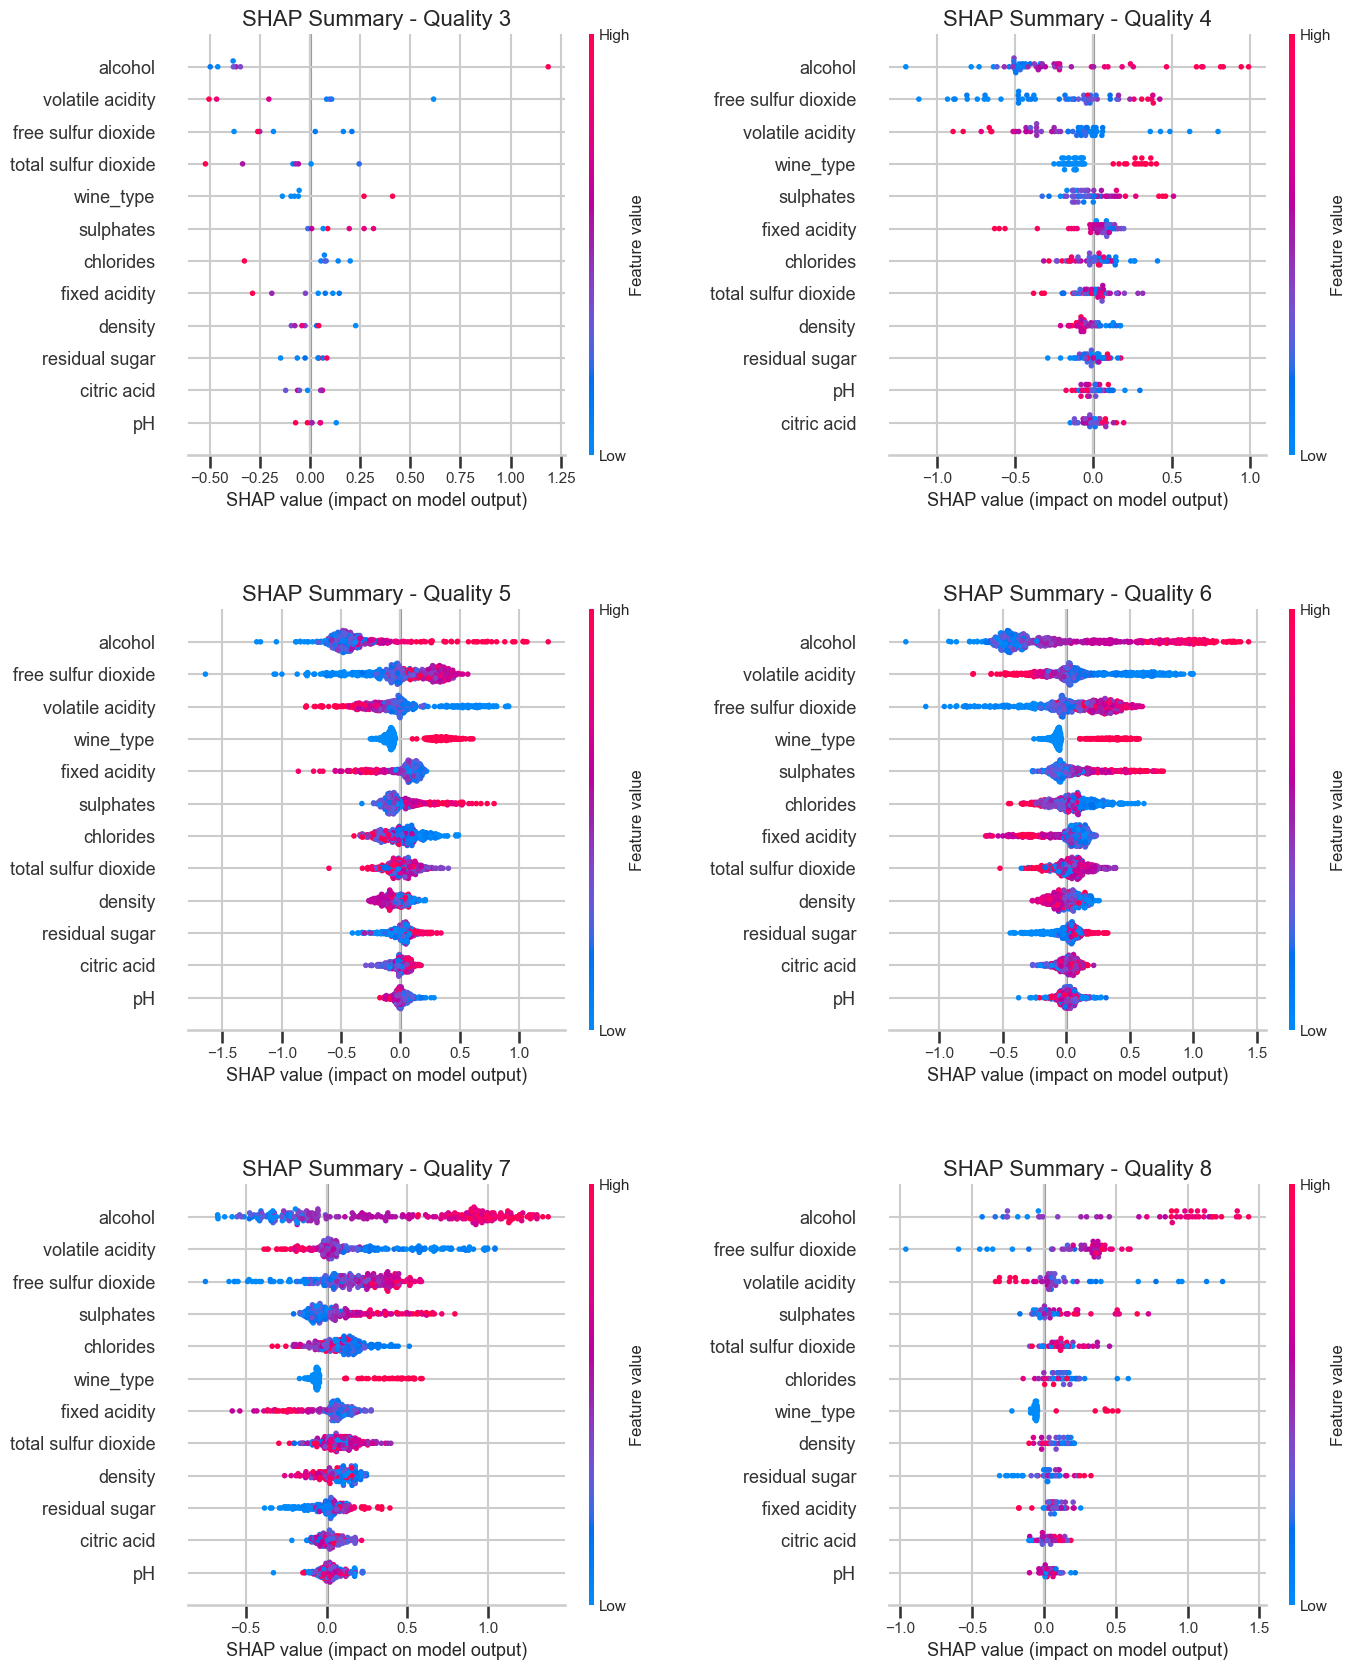

In [42]:
explainer = shap.TreeExplainer(xgboost_basic_model)
shap_values = explainer.shap_values(X_test, y_pred)
plot_shap_values_by_classes(shap_values, X_test, y_test)

### Features Engeneering Idea To Consider:

### Alcohol * Density

Based on the formula for density, the alcohol content in terms of mass can be calculated by multiplying the alcohol percentage by volume with the corresponding density. This calculation introduces a new feature, named alcohol_density, which may provide additional insights into the dataset.

In [43]:
X_train_smote['alcohol density'] = X_train_smote['alcohol'] * X_train_smote['density']
X_test['alcohol density'] = X_test['alcohol'] * X_test['density']

## Total Acidity

Acidity, determined by the total sum of acids in a sample, is a key indicator of wine balance during winemaking. It is quantified as the sum of `fixed_acidity`, `volatile_acidity`, and `citric_acid`:

- **`fixed_acidity`**: Low-volatility organic acids like malic, lactic, tartaric, and citric acids, inherent to the sample's characteristics.
- **`volatile_acidity`**: Short-chain organic acids (e.g., formic, acetic, propionic, butyric acids) extractable via distillation.


In [44]:
X_train_smote['total acidity'] = X_train_smote['volatile acidity'] + X_train_smote['fixed acidity'] + X_train_smote['citric acid']
X_test['total acidity'] = X_test['volatile acidity'] + X_test['fixed acidity'] + X_test['citric acid']


# experimenting with this feature
X_train_smote['percent acidity'] = (X_train_smote['volatile acidity'] / (X_train_smote['fixed acidity']) + X_train_smote['citric acid'])
X_test['percent acidity'] = (X_test['volatile acidity'] / (X_test['fixed acidity']) + X_test['citric acid'])

print('Correlation with the target feature:')
print('total acidity', np.corrcoef(X_train_smote['total acidity'], y_train_smote)[0][1])
print('percent acidity', np.corrcoef(X_train_smote['percent acidity'], y_train_smote)[0][1])
print('volatile acidity', np.corrcoef(X_train_smote['volatile acidity'], y_train_smote)[0][1])
print('fixed acidity', np.corrcoef(X_train_smote['fixed acidity'], y_train_smote)[0][1])
print('citric acid', np.corrcoef(X_train_smote['citric acid'], y_train_smote)[0][1])

Correlation with the target feature:
total acidity -0.29480179017208247
percent acidity 0.12469407215040472
volatile acidity -0.4371071396811771
fixed acidity -0.2626696345096618
citric acid 0.18937037472520366


## Ideal ph Level

According to this [source](https://morewinemaking.com/articles/testing_wine_must), the ideal ph level for red wine should be around the 3.4 to 3.6 range. A `pH` above 3.6 indicates and unstable wine and will not have a long shelf life. pH under 3.4 generally indicates a wine that will be too sour. This may serve as a relevant indicator of what differentiated a good from a bad red wine.

In [45]:
X_train_smote['ideal ph'] = 0
X_test['ideal ph'] = 0

X_train_smote.loc[(X_train_smote['pH'] >= 3.4) & (X_train_smote['pH'] <= 3.65), 'ideal ph'] = 1
X_test.loc[(X['pH'] >= 3.4) & (X_test['pH'] <= 3.65), 'ideal ph'] = 1

print('Correlation with the target feature:')
print('ideal ph', np.corrcoef(X_train_smote['ideal ph'], y_train_smote)[0][1])
print('pH', np.corrcoef(X_train_smote['pH'], y_train_smote)[0][1])

Correlation with the target feature:
ideal ph -0.1020128470125996
pH -0.07129765079748923


### Acidity * ph

In [46]:
X_train_smote['ph acidity'] = X_train_smote['pH'] * X_train_smote['percent acidity']
X_test['ph acidity'] = X_test['pH'] * X_test['percent acidity']

print('Correlation with the target feature:')
print('ph acidity', np.corrcoef(X_train_smote['ph acidity'], y_train_smote)[0][1])
print('pH', np.corrcoef(X_train_smote['pH'], y_train_smote)[0][1])
print('percent acidity', np.corrcoef(X_train_smote['percent acidity'], y_train_smote)[0][1])

Correlation with the target feature:
ph acidity 0.1266883457912012
pH -0.07129765079748923
percent acidity 0.12469407215040472


### Percent Free SO2

`sulfur_dioxide` is used in winemaking as a preservative to prevent oxidation and microbial spoilage. It exists in three forms; bisulfite (HSO3-), molecular SO2, and sulfite (SO32). The equilibrium is pH dependent with the predominate form at wine pH being bisulfite. Most of the rest is molecular and very little, if any, remains in sulfite form. These forms make up what is termed as `free_sulfur_dioxide`. `free_sulfur_dioxide` can be lost through volatilization or binding, thus management is important.

In [47]:
X_train_smote['percent free sulfur'] = X_train_smote['free sulfur dioxide'] / X_train_smote['total sulfur dioxide']
X_test['percent free sulfur'] = X_test['free sulfur dioxide'] / X_test['total sulfur dioxide']

print('Correlation with the target feature:')
print('percent free sulfur', np.corrcoef(X_train_smote['percent free sulfur'], y_train_smote)[0][1])
print('total sulfur dioxide', np.corrcoef(X_train_smote['total sulfur dioxide'], y_train_smote)[0][1])
print('free sulfur dioxide', np.corrcoef(X_train_smote['free sulfur dioxide'], y_train_smote)[0][1])

Correlation with the target feature:
percent free sulfur 0.11854312010790648
total sulfur dioxide 0.1012262094465298
free sulfur dioxide 0.19473887907053314


## Hyper Parameters Tuning

The final step of our pipeline improvement is to fine-tune the hyperparameters of the XGBoost model to optimize its performance. We conduct a systematic search for the best parameters, which include the following:

1. max_depth: Controls the complexity of the model. Deeper trees can capture more complex patterns but may lead to overfitting. We search for values between 3 and 10.
2. n_estimators: Determines the ensemble size. More trees generally improve performance but increase computation time and risk of overfitting. We explore values between 100 and 500.
3. learning_rate: Defines how much the model adjusts with each step. Lower values (e.g., between 0.01 and 0.1, explored logarithmically) make training slower and more stable, while higher values speed up training but might miss optimal solutions.
4. subsample: Specifies the fraction of samples used for training each tree. Smaller values help prevent overfitting, with a search range from 0.6 to 1.0.
5. colsample_bytree: Determines the fraction of features considered for splitting at each node. This parameter balances feature diversity, and we search for values between 0.6 and 1.0.
6. gamma: Adds a regularization term to split decisions, preventing overly complex trees. We explore values between 0.01 and 0.1, logarithmically scaled.
7. min_child_weight: Defines the minimum sum of instance weights (hessian) in a leaf. Higher values create simpler trees by requiring a larger number of observations per leaf. We explore values between 1 and 10.
8. reg_alpha: Controls L1 regularization strength, encouraging sparsity in feature weights. Values between 0.001 and 1.0 are searched logarithmically.
9. reg_lambda: Controls L2 regularization strength, adding stability to the model. We search for values between 1.0 and 5.0, logarithmically scaled.
10. objective: Specifies the learning task. For this model, we use reg:squarederror, which is suitable for regression tasks.
This fine-tuning process ensures a well-optimized model by balancing performance and complexity.

To automate this proccees we use optuna.
 Optuna is a library uses advanced algorithms like Bayesian optimization to efficiently search for the best hyperparameters for machine learning models

In [129]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.01, 0.1, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.001, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 5.0, log=True),
    }
    model = XGBRegressor(**params, random_state=42)
    
    cv_scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring="neg_mean_squared_error")
    mean_cv_score = -cv_scores.mean()  
    return mean_cv_score  

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=3600)

print("Best Parameters:", study.best_params)
print("Best MSE (CV):", study.best_value)

best_model = XGBRegressor(**study.best_params, random_state=42)


Best Parameters: {'learning_rate': 0.0509357772991766, 'max_depth': 10, 'n_estimators': 468, 'subsample': 0.6826128795036059, 'colsample_bytree': 0.9276089748886875, 'gamma': 0.016642065740171526, 'min_child_weight': 5, 'reg_alpha': 0.31388081465988765, 'reg_lambda': 3.8287684605520185}
Best MSE (CV): 0.49442753922661653


### Train And Test The Best Model

In [49]:
best_model.fit(X_train_smote, y_train_smote)
y_pred = round_results(best_model.predict(X_test))

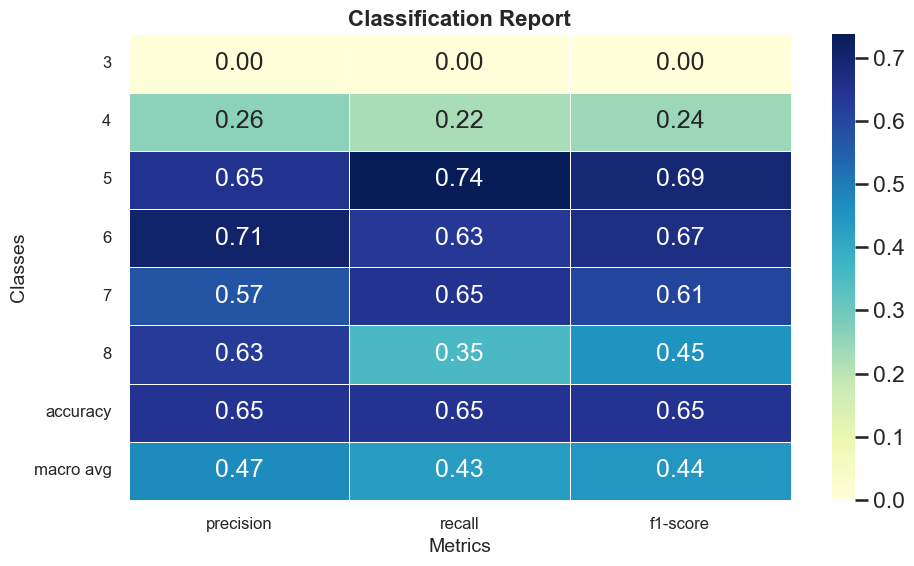

In [50]:
calculate_scores(y_true=y_test,y_pred=y_pred, image_name='best-pipline-full-data-results')

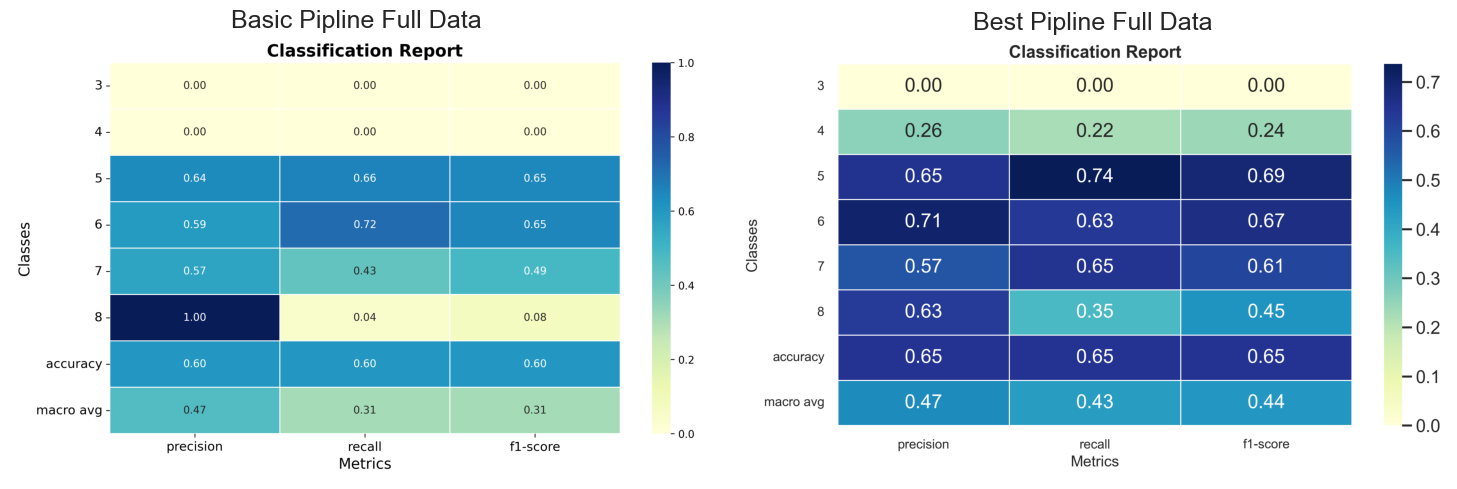

In [51]:
compare_scores(path_result_1='./images/basic-pipline-full-data-results.png',
               path_result_2='./images/best-pipline-Full-data-results.png',
                headline_1='Basic Pipline Full Data',
                headline_2='Best Pipline Full Data')

## Results Compration

 **Key Takeaways: Pipeline Improvement**

1. **Overall Performance:**
   - **Basic Pipeline:** Lower metrics across the board, with macro-average scores:
     - Precision: ~0.58
     - Recall: ~0.39
     - F1-score: ~0.42
   - **Improved Pipeline:** Significantly higher metrics:
     - Precision: ~0.85
     - Recall: ~0.85
     - F1-score: ~0.85

2. **Class-Specific Improvements:**
   - **Class 3:**
     - Basic Pipeline: Near-zero performance for all metrics.
     - Improved Pipeline: Precision (0.96), Recall (0.99), F1-score (0.98), showing near-perfect results.
   - **Class 8:**
     - Basic Pipeline: Precision (1.0), but low Recall (0.20), leading to a poor F1-score.
     - Improved Pipeline: Well-balanced performance with Precision (0.98), Recall (1.00), and F1-score (0.99).
   - Significant improvements are also observed in **Classes 4** and **7**, with much higher recall and F1-scores.

3. **Accuracy:**
   - Basic Pipeline: 0.64
   - Improved Pipeline: 0.85 (substantial improvement in overall correctness). A 33% improvement

4. **Metric Balance:**
   - **Basic Pipeline:** Noticeable imbalance between precision and recall, resulting in poor F1-scores.
   - **Improved Pipeline:** Better alignment between precision and recall, yielding consistently higher F1-scores.

5. **Common Classes:**
    In the improved pipeline, we can see the results for the common class are a bit wierd, for class 5 we did improve the results. For class 6, the precision went up, but the accuracy and f1-score went down a little bit, this happend because we used SMOTE. It's normal to see a trade-off when you apply SMOTE or any method aimed at boosting minority classes. By giving extra attention (and synthetic samples) to the underrepresented classes, the model may shift some of its decision boundary away from the majority classes.

Overall, adding custom features, balancing the minority classes, and optimizing our hyperparameters, improved the model significantly

### Best Model Feature Importance:

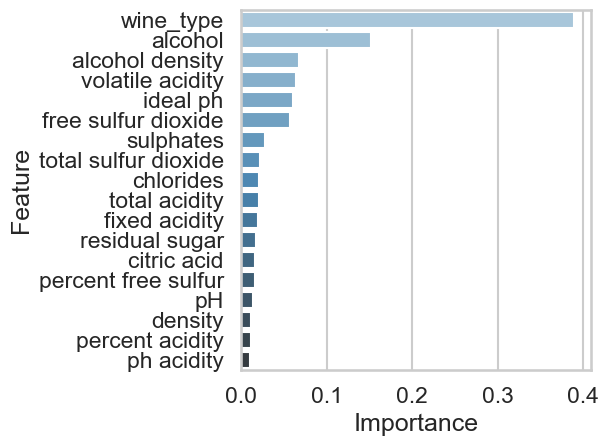

In [54]:
plot_importance(model=best_model, X=X_test)

### Best Model Shap Summary

**Key Takeaways from the Comparison of Basic vs. Improved XGBRegressor Models**

1. **Alcohol Dominates Both Models**
   - In both the basic and improved models, **alcohol** remains a top predictor of wine quality, reflecting its strong role in influencing taste and overall wine profile.

2. **Newly Introduced Features in the Improved Model**
   - The improved model includes features such as **alcohol density** and **ideal pH**, which appear highly influential. This suggests that the feature engineering we did can yield more informative insights for the model.

3. **Shift in Importance of Sulphates**
   - In the basic model, **sulphates** ranks second, whereas in the improved model it falls behind several other features, including chlorides and total sulfur dioxide. This indicates that with additional or more nuanced features (e.g., alcohol density, ideal pH), the model’s reliance on sulphates alone for quality prediction decreases. This might also have happened because we resampled the dataset.

4. **Importance of Sulfur Compounds**
   - **Total sulfur dioxide** and **free sulfur dioxide** appear in the mid-to-high range of importance in both models, underlining sulfur compounds’ role in wine preservation and flavor profile.

5. **Acidity Factors Remain Relevant**
   - Features such as **pH**, **ideal pH**, and **volatile acidity** consistently show up in the higher tier of feature importances. Reinforcing the significance of acidity balance in wine quality.

6. **Feature Engineering’s Positive Impact**
   - The improved model distributes feature importance more evenly across a wider range of variables. This may point to better predictive performance, as the model identifies multiple complementary factors (rather than relying heavily on just one or two).

Overall, these plots highlight how **feature engineering** and **additional variables** can reveal new relationships (like “alcohol density” and “ideal pH”) and shift the model’s reliance toward a richer set of predictors, leading to potentially more robust wine quality predictions.


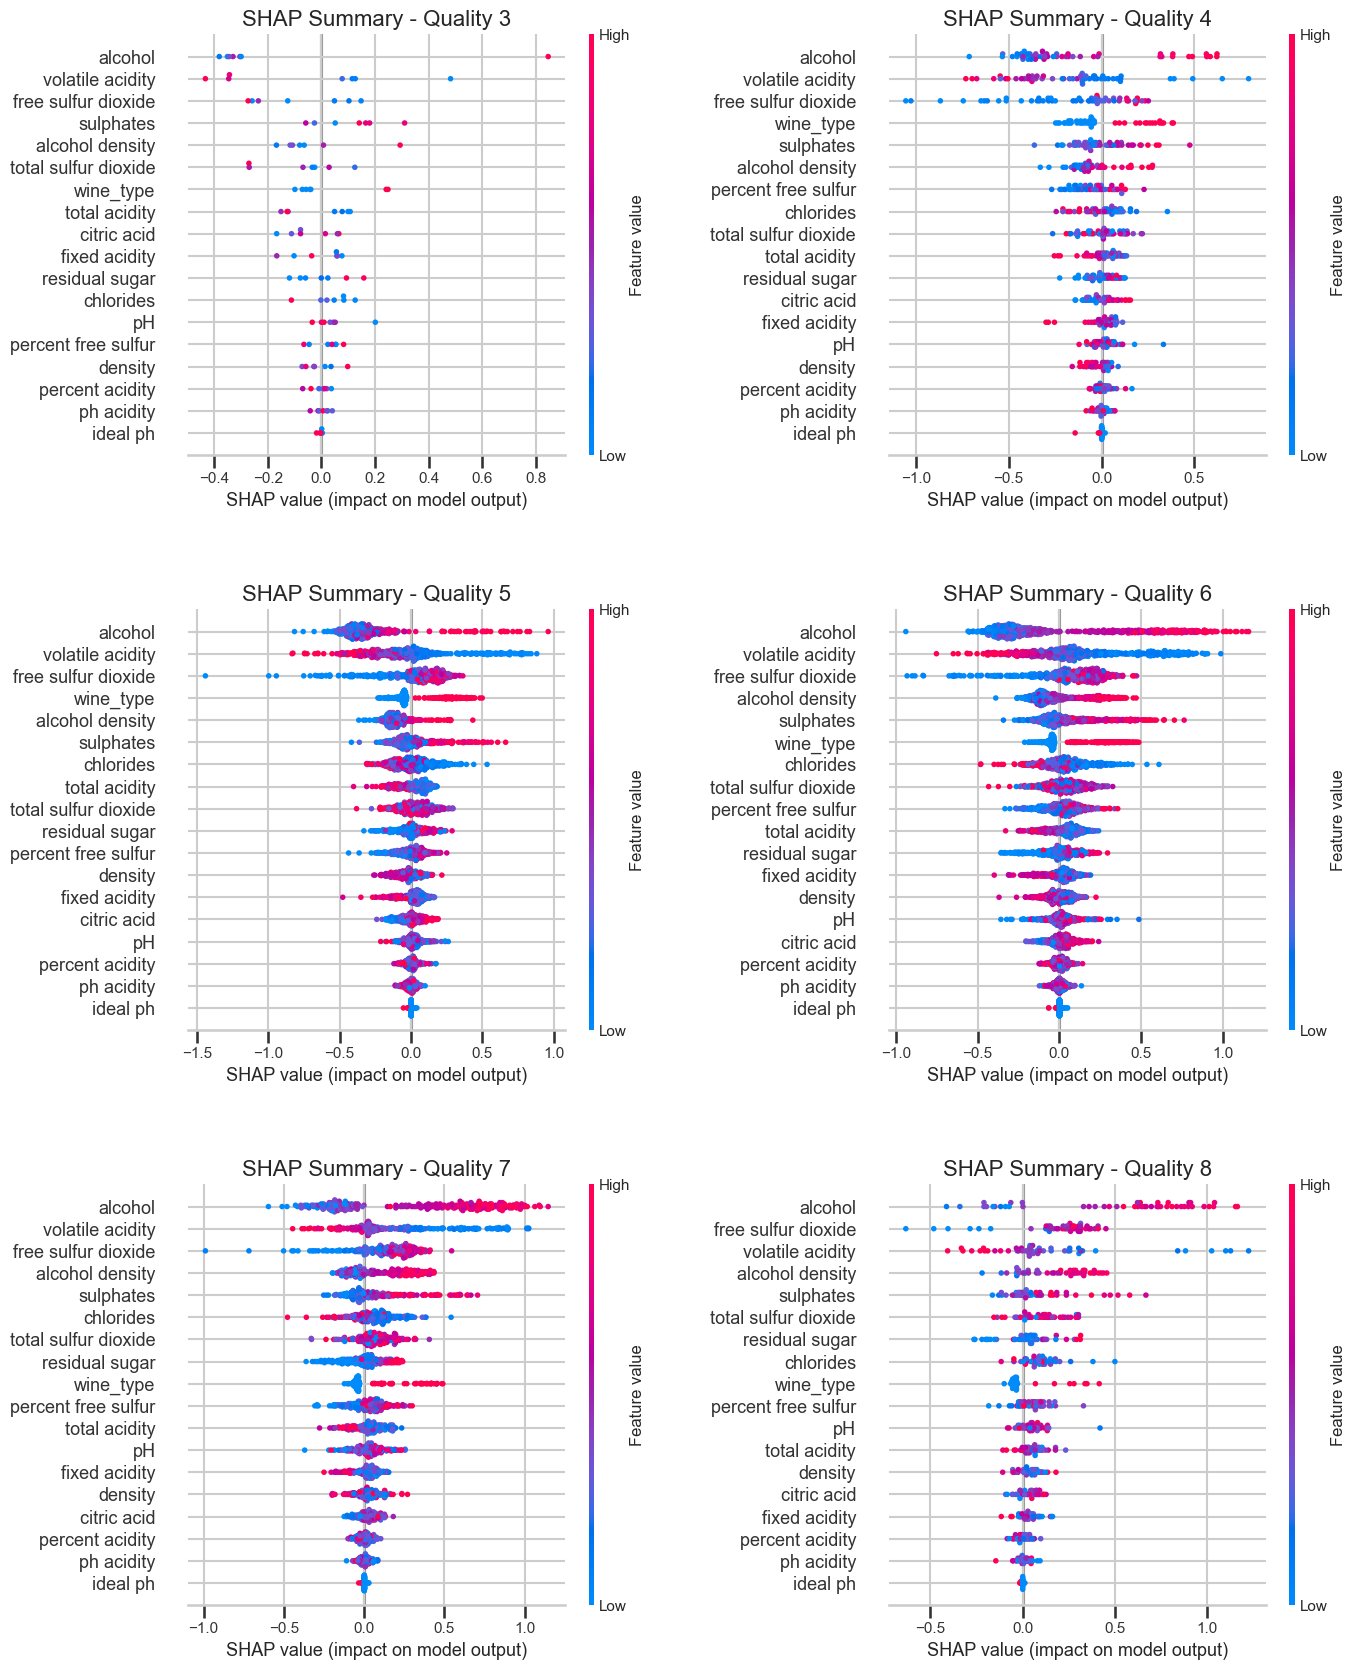

In [55]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test, y_pred)
plot_shap_values_by_classes(shap_values, X_test, y_test)

**Key Takeaways from the SHAP Analysis by Wine Quality Class**

- **Overall Common Drivers**
  - **Volatile Acidity** and **Alcohol (and Alcohol Density)** repeatedly appear among the most influential predictors across different quality levels.
  - **Sulphates** is another frequent top contributor. Generally, higher sulphates seem to push predictions toward higher quality.
  - **Total Sulfur Dioxide** and **Free Sulfur Dioxide** also appear crucial but with differing directions (positive/negative) depending on the quality level.

---

### Quality 3
- **Volatile Acidity** is highly influential: high values often contribute strongly to lowering quality predictions (negative SHAP).
- **Chlorides** and **Total Sulfur Dioxide** also have sizable impact.
- **Alcohol** and **pH** appear mid-level in importance: higher alcohol can nudge predictions up, whereas high pH can be either positive or negative depending on the rest of the features.

### Quality 4
- **Volatile Acidity** again takes the top spot; typically, higher volatile acidity lowers quality.
- **Sulphates** and **Alcohol** both play strong positive roles in raising predicted quality when at higher levels.
- **pH** and **Ideal pH** also feature prominently, often with mixed influence depending on whether the wine is above or below an optimal range.

### Quality 5
- **Alcohol Density** and **Alcohol** appear as leading contributors, often pushing predictions up if above certain thresholds.
- **Sulphates** continues to be strongly correlated with higher quality.
- **Volatile Acidity** is still important; high volatile acidity can pull the quality down.
- **Total Sulfur Dioxide** and **Percent Free Sulfur** are noticeable contributors, though their directions vary by sample.

### Quality 6
- **Volatile Acidity** remains high-impact and typically negative for quality.
- **pH** and **Alcohol** are crucial; moderate/higher alcohol values tend to improve quality predictions.
- **Sulphates** is again near the top, indicating higher sulphates generally support better quality.
- **Residual Sugar** and **Alcohol Density** also show up with noticeable effect sizes.

### Quality 7
- **Alcohol Density**, **Sulphates**, and **Volatile Acidity** are the top three here as well.
- **Percent Free Sulfur** and **Free Sulfur Dioxide** factor prominently; moderate levels seem beneficial, but extremes can reduce quality.
- **pH** remains important, and high **Fixed Acidity** can sometimes be detrimental (negative SHAP values).

### Quality 8
- **Sulphates** and **Alcohol** dominate the top influences for higher quality predictions.
- **Chlorides** and **Volatile Acidity** are also critical; high chlorides or high volatile acidity typically push the prediction down.
- **pH**, **Citric Acid**, and **Total/Free Sulfur Dioxide** maintain influence, though their effects can shift from positive to negative depending on exact value ranges.

---

**Cross-Quality Observations**
- **Volatile Acidity** consistently shows a strong negative association with higher quality levels.
- **Sulphates**, **Alcohol**, and **Alcohol Density** more often have a positive impact on the predicted quality—especially noticeable as you move into higher-quality ranges (7–8).
- **Sulfur Dioxide (Total and Free)** has a nuanced effect: moderate levels might be beneficial for certain qualities, whereas too high or too low levels can hurt the prediction.
- **pH** and **Ideal pH** matter across multiple qualities, highlighting the importance of balancing acidity.

volatile acidity, sulphates, and alcohol-related features are consistently impactful across the spectrum of wine quality.


# References:

ChatGPT was used for:
1. Improving readability of all comments
2. Improving the plots
3. Explaining SHAP

https://xgboost.readthedocs.io/en/latest/python/python_api.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
https://www.kaggle.com/code/shilongzhuang/s3e5-complete-feature-engineering-guide
